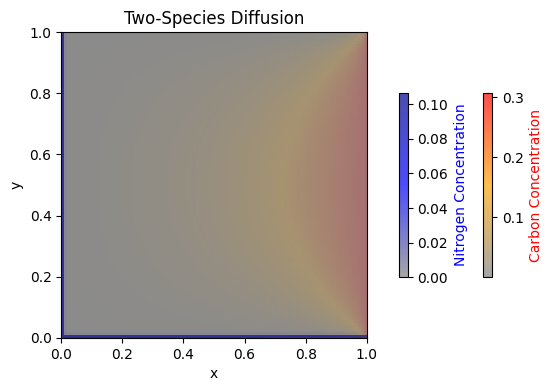

In [1]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Parameters
nx, ny = 100, 100
dx = dy = 1.0 / (nx - 1)
dt = 0.01
nt = 1000
Dc_u = 0.045  # Carbon (right) in gamma Steel at 873 K = 4.5 * 10 ^-2 micro m2/s = 4.5 * 10 ^-14 M^2/s
Dc_v = 0.0045  # Nitrogen (left) in 304 Stainless steel at 900 K = 4.5 * 10 ^-3 micro m^2/s = 4 * 10 ^-15 M^2/s
alpha_x_u = Dc_u * dt / (2 * dx**2)
alpha_y_u = Dc_u * dt / (2 * dy**2)
alpha_x_v = Dc_v * dt / (2 * dx**2)
alpha_y_v = Dc_v * dt / (2 * dy**2)
c_surface = 1

# Initial conditions
u = np.zeros((nx, ny))  # Carbon
v = np.zeros((nx, ny))  # Nitrogen

# Construct 2D matrices
n = nx * ny
main_diag = np.ones(n) * (1 + 2*alpha_x_u + 2*alpha_y_u)
x_off_diag = np.ones(n-1); x_off_diag[nx-1::nx] = 0
y_off_diag = np.ones(n - nx)

A_u = diags([main_diag, -alpha_x_u*x_off_diag, -alpha_x_u*x_off_diag,
             -alpha_y_u*y_off_diag, -alpha_y_u*y_off_diag],
            [0, -1, 1, -nx, nx], shape=(n, n)).tocsr()

A_v = diags([main_diag, -alpha_x_v*x_off_diag, -alpha_x_v*x_off_diag,
             -alpha_y_v*y_off_diag, -alpha_y_v*y_off_diag],
            [0, -1, 1, -nx, nx], shape=(n, n)).tocsr()

# Time-stepping
for _ in range(nt):
    # Solve for u (carbon from right)
    b_u = u.flatten().copy()
    b_u[ny-1::ny] = c_surface  # Right side
    u = spsolve(A_u, b_u).reshape((nx, ny))
    #u[0, :] = 0  # Bottom
    u[-1, :] = u[-2, :]  # Top Neumann

    # Solve for v (nitrogen from left)
    b_v = v.flatten().copy()
    b_v[::ny] = c_surface  # Left side
    b_v[:ny] = c_surface   # Bottom side (y = 0) – first row
    v = spsolve(A_v, b_v).reshape((nx, ny))
    #v[0, :] = 0  # Bottom
    v[-1, :] = v[-2, :]  # Top Neumann

# After solving
u_plot = np.where(u <= 0, np.nan, u)
v_plot = np.where(v <= 0, np.nan, v)

# For carbon: red → orange → yellow
colors_u = ['gray', 'orange', 'red']
cmap_u = LinearSegmentedColormap.from_list('carbon_grad', colors_u)
cmap_u.set_bad('black')
# For nitrogen: blue → cyan → white
colors_v = ['gray', 'blue', 'darkblue']
cmap_v = LinearSegmentedColormap.from_list('nitrogen_grad', colors_v)
cmap_v.set_bad('black')
plt.figure()

im1 = plt.imshow(u_plot, extent=[0,1,0,1], origin='lower', cmap=cmap_u, alpha=0.7, zorder=1)
im2 = plt.imshow(v_plot, extent=[0,1,0,1], origin='lower', cmap=cmap_v, alpha=0.7, zorder=2)   
 
# Add separate colorbars
cb1 = plt.colorbar(im1, ax=plt.gca(), shrink=0.5, pad=0.05)
cb1.set_label('Carbon Concentration', color='red')

cb2 = plt.colorbar(im2, ax=plt.gca(), shrink=0.5, pad=0.08)
cb2.set_label('Nitrogen Concentration', color='blue')

plt.xlabel('x'); plt.ylabel('y')
plt.title('Two-Species Diffusion')
plt.show()
